In [1]:
#Lets make a ReAct (Reason + Action) agent using LangGraph .
#The Architecture of the agent is going to be simple . One llm node, one action node and 
#the conditional edges and one edge for looping from action node to the llm



In [2]:
#First we need to import the libraries and the essential classes 
#dotenv to get the api key from .env
from dotenv import load_dotenv
_ = load_dotenv()

In [3]:
#Then we need to use a graph called State Graph . State Graph is a type of graph that keeps the remembers the state of the graph , 
#which will be helpful for context 
from langgraph.graph import StateGraph, END #END represents the terminal node of the graph

from typing import TypedDict, Annotated    # TypedDict is a class that allows us to define a dictionary with the specified type 
#and Annotated is used to add some explaination text with the datatpye 


In [4]:
#Now Lets import other things 
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [5]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [6]:
# Define the shape of the shared state for our graph‑based agent.
# We use TypedDict so Python (and tools like mypy) know exactly which keys exist.


class AgentState(TypedDict):
    messages : Annotated[list[AnyMessage],operator.add]

    
#This state inherits the TypedDict . 
# The `messages` key holds the entire conversation history—
# a list of AnyMessage instances (HumanMessage, AIMessage, ToolMessage, etc.).
#
# We wrap the type in Annotated[..., operator.add] to tell LangGraph:
#   “When a node returns new messages, append them to the existing list,
#    rather than replacing the list outright.”
#
# operator.add is simply Python’s list‑concatenation function,
# so state['messages'] + new_messages becomes the updated history

In [7]:
from langgraph.checkpoint.sqlite import SqliteSaver

from contextlib import ExitStack

# Use contextlib to manually enter the context manager and keep the object
stack = ExitStack()

# Create the memory context manager and enter the context
memory= stack.enter_context(SqliteSaver.from_conn_string(":memory:"))


In [8]:
# Define the Agent class that drives the conversational flow using a state graph
class Agent:
    def __init__(self, tools, model, checkpointer,system_message=""):
        self.system_message = system_message  # Optional system message to guide LLM behavior

        # Create a new state graph where each node represents a step in the agent's reasoning
        graph = StateGraph(AgentState)

        # Add the LLM node: calls the model to generate a response
        graph.add_node("llm", self.call_openai)

        # Add the action node: calls tools if the model requests them
        graph.add_node("action", self.take_action)

        # Set up a conditional path: if the LLM response includes a tool call, go to 'action' node
        # Otherwise, end the graph execution
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )

        # After executing the action, loop back to the LLM to continue the conversation
        graph.add_edge("action", "llm")

        # Define the entry point of the graph (start from LLM)
        graph.set_entry_point("llm")

        # Compile the graph so it can be executed
        self.graph = graph.compile(checkpointer=checkpointer)

        # Store tools in a dictionary for easy lookup by name
        self.tools = {t.name: t for t in tools}

        # Bind the tools to the model (e.g., OpenAI with tool-calling support)
        self.model = model.bind_tools(tools)

    # This function checks if the latest LLM message includes any tool calls
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    # This function sends the messages to the model and gets a new response
    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system_message:
            # Prepend the system message to guide the model if it's provided
            messages = [SystemMessage(content=self.system_message)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    # This function is responsible for executing tool calls requested by the model
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:  # Check if the tool name is valid
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # Instruct LLM to retry on invalid tool call
            else:
                # Call the actual tool with provided arguments
                result = self.tools[t['name']].invoke(t['args'])

            # Wrap the tool result in a ToolMessage to pass it back to the model
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

        print("Back to the model!")  # Indicates loop back to model
        return {'messages': results}


In [9]:


prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
bot = Agent([tool],model, checkpointer=memory,system_message=prompt)

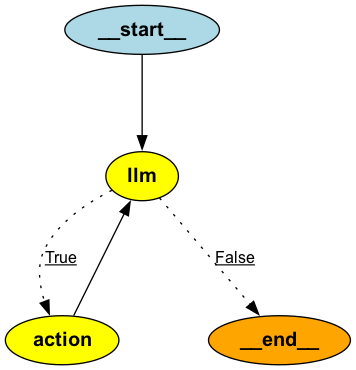

In [11]:
from IPython.display import Image

Image(bot.graph.get_graph().draw_png())


## Now Lets Use persistence and Streaming

In [12]:
messages = [HumanMessage(content="What is the weather in sf?")]

In [13]:
thread = {"configurable": {"thread_id": "1"}}

In [15]:
for event in bot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YDX5lzFtJ1czVNBnXy3JTH9N', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 153, 'total_tokens': 175, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BUuu6GukW50LDXcSTvqGgaJCp1xJN', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4c6dd794-ce04-4756-b8ed-edb3a60984ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_YDX5lzFtJ1czVNBnXy3JTH9N', 'type': 'tool_call'}], usage_metadata={'input_tokens': 153, 'output_token

In [16]:
messages = [HumanMessage(content="What about in la?")]
thread = {"configurable": {"thread_id": "1"}}
for event in bot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_J6Th3fH2wdjxfHbiu2OrKcRO', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 1676, 'total_tokens': 1698, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BUuuM6hXJSv5SlchxXLVPI36ndedg', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e4d656dc-94ef-4312-857c-bc8d335ef6d6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_J6Th3fH2wdjxfHbiu2OrKcRO', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1676, '

In [18]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "1"}}
for event in bot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='San Francisco is currently warmer than Los Angeles. San Francisco has a temperature of 66°F while Los Angeles has a temperature of 57°F.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 3311, 'total_tokens': 3342, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BUuunCiHHxaGvoZL8XL4BzIbxxzH1', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--40fd68eb-6b21-4d4c-b4aa-6a4e0616abf7-0', usage_metadata={'input_tokens': 3311, 'output_tokens': 31, 'total_tokens': 3342, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [19]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "2"}}
for event in bot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='Sure, I can look up information to compare the temperature of two different places. Please provide the names of the places you would like me to compare for their current temperatures.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 151, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BUuv17nkNhYIuEK5nzE0B0ZQAiOfQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--bd1d0b61-530c-4b2f-8356-97194a26ee89-0', usage_metadata={'input_tokens': 151, 'output_tokens': 36, 'total_tokens': 187, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
